In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import VGG16
import timeit

In [2]:
levels = ['Normal', 'COVID']
path = "E:/AI-final/Quang not covid/VGG16_covid-main/data/aaaacovi/COVID-19_Radiography_Dataset/"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level + '/images')):
        data.append(['{}/images/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'result'])

data['path'] = path + '/' + data['image_file']

data.head()

,image_file,result,path
0,Normal/images/Normal-10000.png,Normal,E:/AI-final/Quang not covid/VGG16_covid-main/d...
1,Normal/images/Normal-10001.png,Normal,E:/AI-final/Quang not covid/VGG16_covid-main/d...
2,Normal/images/Normal-10002.png,Normal,E:/AI-final/Quang not covid/VGG16_covid-main/d...
3,Normal/images/Normal-10003.png,Normal,E:/AI-final/Quang not covid/VGG16_covid-main/d...
4,Normal/images/Normal-10004.png,Normal,E:/AI-final/Quang not covid/VGG16_covid-main/d...


In [3]:
print("Numbers of X-ray images: {}".format(data.shape[0]))

Numbers of X-ray images: 7841


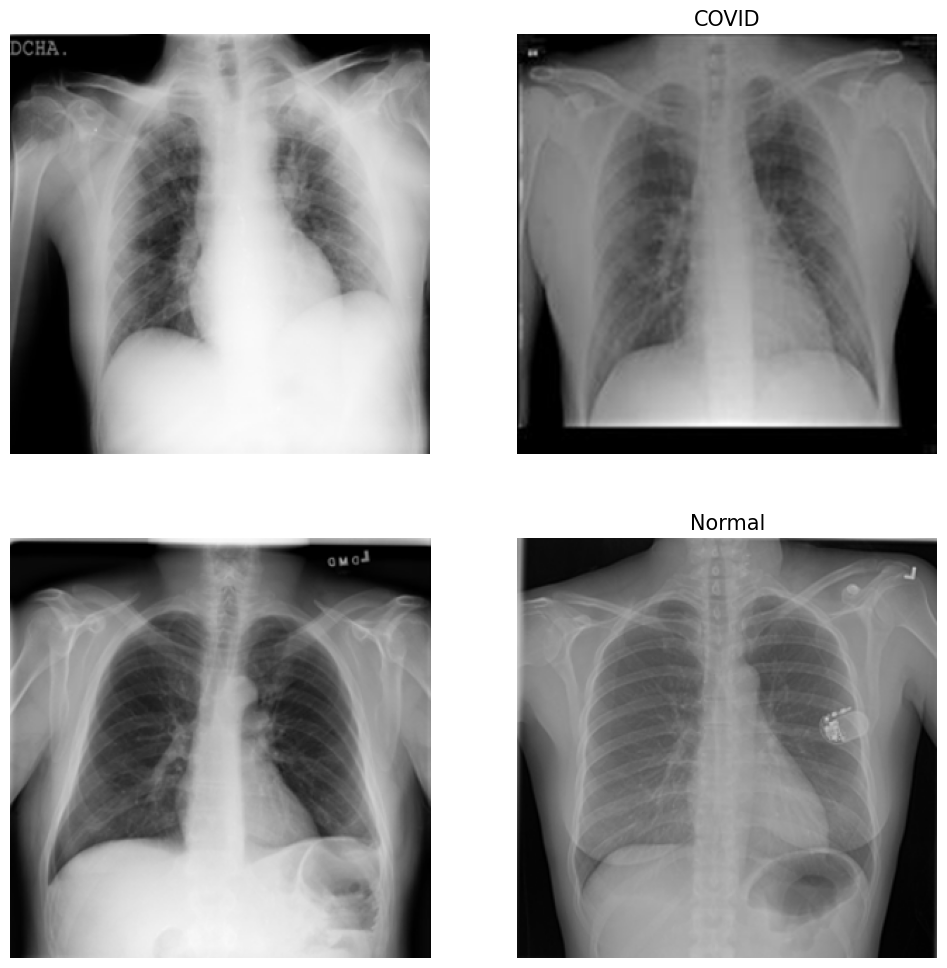

In [4]:
BATCH_SIZE = 2

fig, m_axs = plt.subplots(2, BATCH_SIZE, figsize = (6*BATCH_SIZE, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['result']).groupby('result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(BATCH_SIZE, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [5]:
print('Normal : ', list(data['result']).count('Normal'))
print('Covid : ', list(data['result']).count('COVID'))


Normal :  4225
Covid :  3616


In [6]:
round(data['result'].value_counts() / data.shape[0] * 100,2)

Normal    53.88
COVID     46.12
Name: result, dtype: float64

In [7]:
pixel_img = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((1,64,64))
    pixel_img.append(img)

100%|██████████| 7841/7841 [01:18<00:00, 100.11it/s]


In [8]:
pixel_img = np.array(pixel_img)
label_img = data['result'].map({'Normal': 0, 'COVID': 1})

print(pixel_img.shape, label_img.shape)

(7841, 1, 64, 64) (7841,)


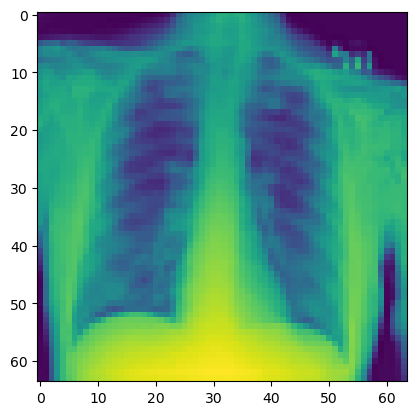

In [9]:
plt.imshow(pixel_img[200][0])

In [10]:
#20% will be used for test
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img, )
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6272, 1, 64, 64)
(1569, 1, 64, 64)
(6272,)
(1569,)


Input Normalize

In [11]:
X_train = X_train /255
X_test = X_test / 255

print(X_train.shape)
print(X_test.shape)

(6272, 1, 64, 64)
(1569, 1, 64, 64)


Output Normalize

In [12]:
y_train = np.atleast_2d(y_train).reshape(-1,1)
y_test = np.atleast_2d(y_test).reshape(-1,1)

In [13]:
y_train.shape

(6272, 1)

In [14]:
# def one_hot_encode(y,num_classes):
#   y_onehot = np.zeros((y.shape[0],num_classes))
#   for i,label in enumerate(y):
#     y_onehot[i][label] = 1
#   return y_onehot

In [15]:
# y_train_onehot = one_hot_encode(y_train,2)
# y_test_onehot = one_hot_encode(y_test,2)

In [16]:
# y_train_onehot.shape

In [17]:
def get_every_n(X, y, n=32):
    full_chunks_len = X.shape[0] // n
    for i in range(full_chunks_len):
        yield X[n*i:n*(i+1)], np.reshape(y[n*i:n*(i+1)], (-1, n))
        X_batch = X[full_chunks_len*n:]
        y_batch = np.reshape(y[full_chunks_len*n:,:], (-1, n))
    yield X_batch, y_batch

In [18]:
for x, y in get_every_n(X_train, y_train, 2):
    print(x.shape)
    print(y.shape)
    break

(2, 1, 64, 64)
(1, 2)


In [1]:
start = timeit.default_timer()
model = VGG16.CNN(X_train.shape)

model.addLayer(VGG16.Conv_layer(kernel_size=3, n_kernels=16))
model.addLayer(VGG16.Pool_layer(2))
model.addLayer(VGG16.BatchNorm())

model.addLayer(VGG16.Conv_layer(kernel_size=3, n_kernels=8))
model.addLayer(VGG16.Pool_layer(2))
model.addLayer(VGG16.Reshape())
model.addLayer(VGG16.FullyConnected([10, 10], y_train.shape[1],VGG16.Tanh))
model.compile()

for x, y in get_every_n(X_train, y_train, 2):
    print(x.shape)
    print(y.shape)
    model.train(x, y,X_test, y_test, 0.09, 5)
stop = timeit.default_timer()
print('Time: ', stop - start)  


NameError: name 'timeit' is not defined

In [ ]:
model.save('model1.h5')

AttributeError: 'CNN' object has no attribute 'save'

0.0
0.0


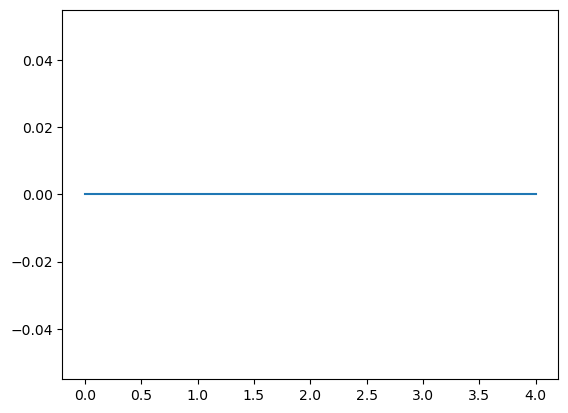

In [ ]:
plt.plot(model.cost_his)
print(model.cost_his[0])
print(model.cost_his[1])

(299, 299, 3)


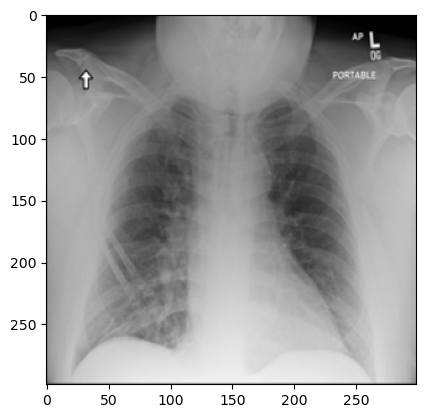

In [ ]:
import cv2
img = cv2.imread('Normal-9989.png')
print(img.shape)
plt.imshow(img)

In [ ]:
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

(299, 299)


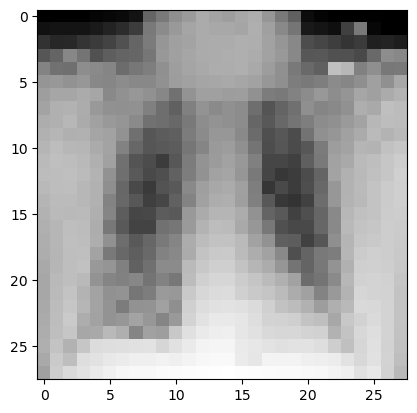

In [ ]:
img_new = cv2.resize(gray_img,(28,28))
print(gray_img.shape)
plt.imshow(img_new,cmap='gray')

In [ ]:
img_scaled =np.array([img_new/255.])
print(img_scaled.shape)
y_hat = model.predict(img_scaled)
print(y_hat)
print(np.argmax(y_hat)) # index tai vi tri lon nhat

(1, 28, 28)


AttributeError: 'CNN' object has no attribute 'fit'